In [2]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Open the data file from Plenticore Inverter (measured data)

The datafile will be opened and adapted to fit the required formats.

In [3]:
#data_file = os.path.join(os.getcwd(), "pv_data", "2021_q1.csv")
data_file = os.path.join(os.getcwd(), "pv_data", "2021_04_02.csv")
mydf = pd.read_csv(data_file, skiprows=6, delimiter="\t", index_col="Zeit")
mydf.index = pd.to_datetime(mydf.index, unit='s')
mydf.index = mydf.index.tz_localize('UTC') + pd.offsets.Hour(1)
mydf.index = mydf.index.tz_convert('Europe/Berlin')
mydf = mydf[mydf["DC1 U"].notna()]
mydf = mydf[mydf["DC1 U"].notna()]
mydf["DC1_I_A"] = mydf["DC1 I"] / 1000.0   # convert from mA to ampere
mydf["DC2_I_A"] = mydf["DC2 I"] / 1000.0   # convert from mA to ampere
mydf["ALL_AC_POWER"] = mydf["DC1 P"] + mydf["DC2 P"]
mydf["Consumption"] = mydf["HC2 P"] + mydf["HC2 P"]


In [4]:
pv_gen_hourly = mydf.groupby(pd.Grouper(freq='H', closed='right')).mean()

# Open the forecast data

In [5]:
data_file = os.path.join(os.getcwd(), "output", "2021_04_02_09_29_Uhr.csv")

forecast_data = pd.read_csv(data_file, index_col="DATE")
forecast_data.index = pd.to_datetime(forecast_data.index)
forecast_data.columns

Index(['WIND_DIRECTION', 'WIND_SPEED', 'CLOUD_COVER_TOTAL',
       'PRESSURE_AIR_SURFACE_REDUCED', 'PROBABILITY_RADIATION_GLOBAL_LAST_1H',
       'RADIATION_GLOBAL', 'TEMPERATURE_AIR_200', 'TEMPERATURE_DEW_POINT_200',
       'WEATHER_SIGNIFICANT', 'TEMPERATURE_AIR_200DEGC', 'DEW_POINT_DEGC',
       'RAD_WH', 'DHI_ERBS', 'DNI_DISC', 'DNI_DIRINDEX', 'GHI_CLEARSKY',
       'DNI_CLEARSKY', 'DHI_CLEARSKY', 'AZIMUTH', 'ZENITH', 'ELEVATION',
       'Ost_ac', 'Ost_aoi', 'Ost_cell_temperature', 'Ost_effective_irradiance',
       'Ost_dc_i_sc', 'Ost_dc_v_oc', 'Ost_dc_i_mp', 'Ost_dc_v_mp',
       'Ost_dc_p_mp', 'Ost_dc_i_x', 'Ost_dc_i_xx', 'Ost_diode_params_I_L',
       'Ost_diode_params_I_o', 'Ost_diode_params_R_s', 'Ost_diode_params_R_sh',
       'Ost_diode_params_nNsVth', 'Ost_total_irrad_poa_global',
       'Ost_total_irrad_poa_direct', 'Ost_total_irrad_poa_diffuse',
       'Ost_total_irrad_poa_sky_diffuse', 'Ost_total_irrad_poa_ground_diffuse',
       'West_ac', 'West_aoi', 'West_cell_temper

# Viusalize daza
## Overall power output

In [17]:
today = datetime.date.today()# + datetime.timedelta(days=1)
start = datetime.datetime(year=today.year, month=today.month, day=today.day, hour=5)
start = pd.Timestamp(start).tz_localize('utc')
end = datetime.datetime(year=today.year, month=today.month, day=today.day, hour=23)
end = pd.Timestamp(end).tz_localize('utc')
data_pv_h = pv_gen_hourly.loc[start:end]
data_pv_overall = mydf.loc[start:end]
forecast_h = forecast_data.loc[start:end]


## Overall power output

<AxesSubplot:title={'center':'Generated and forecasted Power vs. Consumption'}, xlabel='Time', ylabel='Power [W]'>

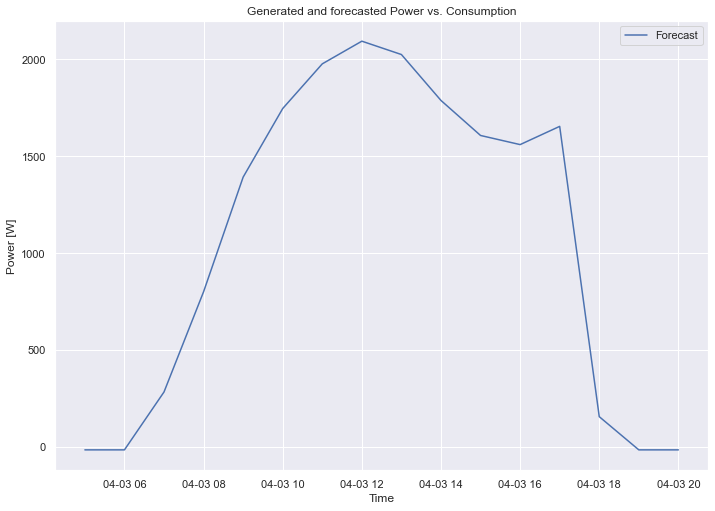

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Power [W]")
ax.set_title("Generated and forecasted Power vs. Consumption")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="Zeit", y="ALL_AC_POWER", data=data_pv_h, label="Measured", ax=ax)
sns.lineplot(x=forecast_h.index, y="ALL_AC_POWER", data=forecast_h, label="Forecast", ax=ax)
sns.lineplot(x="Zeit", y="Consumption", data=data_pv_overall, label="House Consumption", ax=ax)
sns.lineplot(x="Zeit", y="Consumption", data=data_pv_h, label="House Consumption (1h mean)", ax=ax)
sns.lineplot(x="Zeit", y="HC2 P", data=data_pv_overall, label="From PV", ax=ax)
sns.lineplot(x="Zeit", y="HC3 P", data=data_pv_overall, label="From Grid", ax=ax)

## Power per String


<AxesSubplot:title={'center':'Generated and forecasted Power by String'}, xlabel='Time', ylabel='Power [W]'>

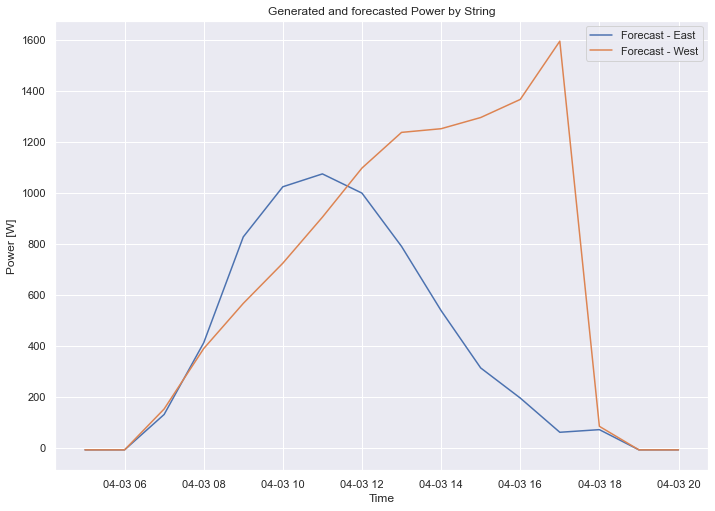

In [19]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Power [W]")
ax.set_title("Generated and forecasted Power by String")
sns.lineplot(x="Zeit", y="DC2 P", data=data_pv_h, label="Measured - East", ax=ax)
sns.lineplot(x="Zeit", y="DC1 P", data=data_pv_h, label="Measured - West", ax=ax)
sns.lineplot(x=forecast_h.index, y="Ost_ac", data=forecast_h, label="Forecast - East", ax=ax)
sns.lineplot(x=forecast_h.index, y="West_ac", data=forecast_h, label="Forecast - West", ax=ax)

## Realized Production

<AxesSubplot:title={'center':'Generation vs. Forecasted generation'}, xlabel='Type', ylabel='value'>

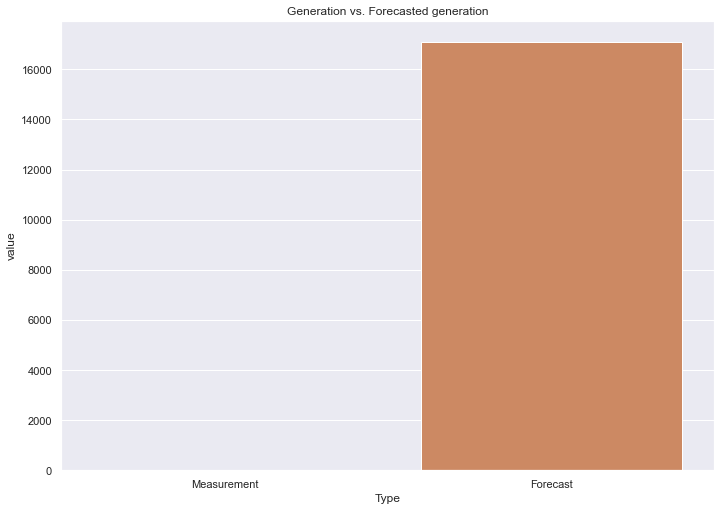

In [20]:
fig, ax = plt.subplots()
ax.set_xlabel("") 
ax.set_ylabel("Generation [Wh]")
ax.set_title("Generation vs. Forecasted generation")
overall_production = data_pv_h["ALL_AC_POWER"].loc[data_pv_h["ALL_AC_POWER"] > 0].sum()
overall_forecast = forecast_h["ALL_AC_POWER"].loc[forecast_h["ALL_AC_POWER"] > 0].sum()
overall = pd.DataFrame({'Type': ["Measurement", "Forecast"],
                        "value": [overall_production, overall_forecast]})


sns.barplot(x="Type", y="value", data=overall)

## Production summary

### Overall

In [21]:
print(f"Prodution realized:   {overall_production / 1000} kWh")
print(f"Prodution forecasted: {overall_forecast / 1000} kWh")

Prodution realized:   0.0 kWh
Prodution forecasted: 17.086634895202028 kWh


### East

In [22]:
val = data_pv_h["DC2 P"].loc[data_pv_h["DC2 P"] > 0].sum()
print(f"Prodution realized:   {val / 1000} kWh")
val = forecast_h["Ost_ac"].loc[forecast_h["Ost_ac"] > 0].sum()
print(f"Prodution forecasted: {val / 1000} kWh")

Prodution realized:   0.0 kWh
Prodution forecasted: 6.4315165478433896 kWh


### West

In [23]:
val = data_pv_h["DC1 P"].loc[data_pv_h["DC1 P"] > 0].sum()
print(f"Prodution realized:   {val / 1000} kWh")
val = forecast_h["West_ac"].loc[forecast_h["West_ac"] > 0].sum()
print(f"Prodution forecasted: {val / 1000} kWh")

Prodution realized:   0.0 kWh
Prodution forecasted: 10.65511834735864 kWh


## DC Properties
### Voltage

<AxesSubplot:title={'center':'Currents per String - Forecast vs. Measurement'}, xlabel='Time', ylabel='Current [V]'>

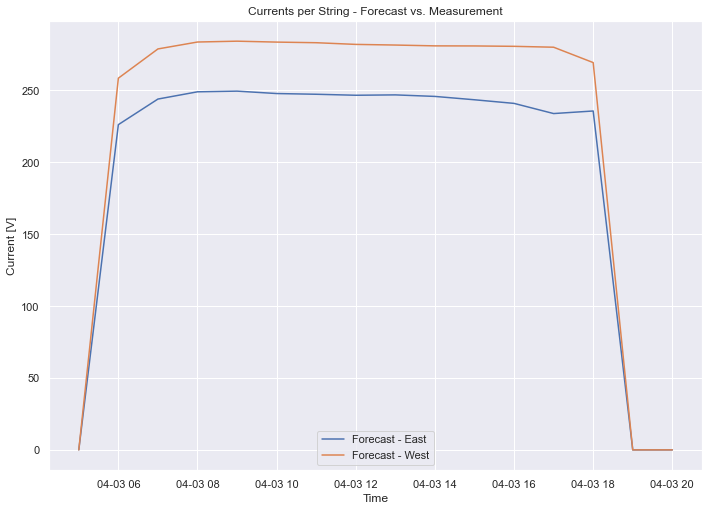

In [24]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Current [V]")
ax.set_title("Currents per String - Forecast vs. Measurement")
sns.lineplot(x="Zeit", y="DC2 U", data=data_pv_h, label="Measured - East")
sns.lineplot(x="Zeit", y="DC1 U", data=data_pv_h, label="Measured - West")
sns.lineplot(x=forecast_h.index, y="Ost_dc_v_mp", data=forecast_h, label="Forecast - East")
sns.lineplot(x=forecast_h.index, y="West_dc_v_mp", data=forecast_h, label="Forecast - West")

<AxesSubplot:title={'center':'Currents per String - Forecast vs. Measurement - different resolution'}, xlabel='Time', ylabel='Current [V]'>

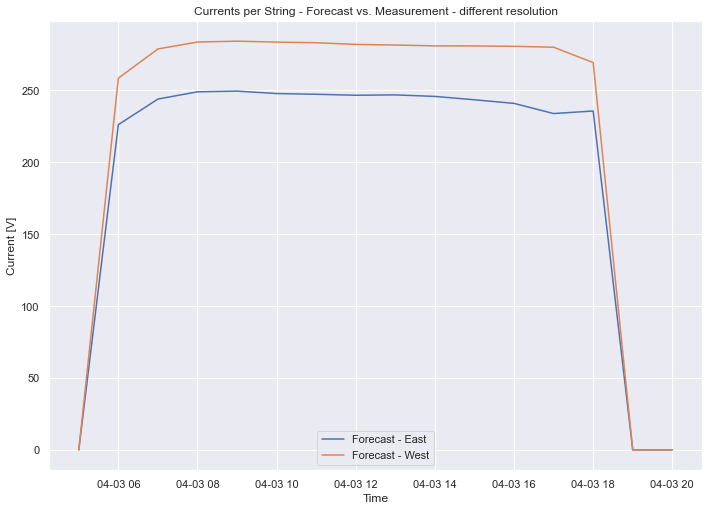

In [25]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Current [V]")
ax.set_title("Currents per String - Forecast vs. Measurement - different resolution")
sns.lineplot(x="Zeit", y="DC2 U", data=data_pv_h, label="Measured - East (1h mean")
sns.lineplot(x="Zeit", y="DC1 U", data=data_pv_h, label="Measured - West (1h mean)")
sns.lineplot(x="Zeit", y="DC2 U", data=data_pv_overall, label="Measured - East")
sns.lineplot(x="Zeit", y="DC1 U", data=data_pv_overall, label="Measured - West")
sns.lineplot(x=forecast_h.index, y="Ost_dc_v_mp", data=forecast_h, label="Forecast - East")
sns.lineplot(x=forecast_h.index, y="West_dc_v_mp", data=forecast_h, label="Forecast - West")

### Amperage

<AxesSubplot:title={'center':'Amperage per String - Forecast vs. Measurement - different resolution'}, xlabel='Time', ylabel='Amperage [A]'>

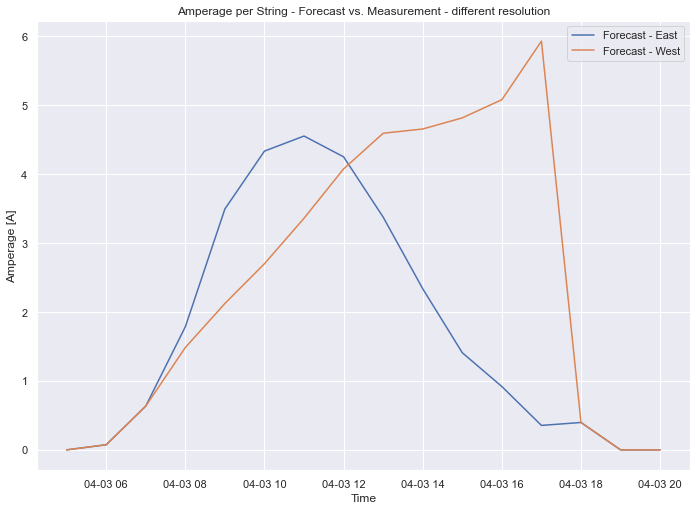

In [26]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Amperage [A]")
ax.set_title("Amperage per String - Forecast vs. Measurement - different resolution")
sns.lineplot(x="Zeit", y="DC2_I_A", data=data_pv_h, label="Measured - East")
sns.lineplot(x="Zeit", y="DC1_I_A", data=data_pv_h, label="Measured - West")
sns.lineplot(x=forecast_h.index, y="Ost_dc_i_mp", data=forecast_h, label="Forecast - East")
sns.lineplot(x=forecast_h.index, y="West_dc_i_mp", data=forecast_h, label="Forecast - West")

## Wheater and Irradiance
### Module temperature

<AxesSubplot:title={'center':'Air temperature vs. forecasted module temperature'}, xlabel='Time', ylabel='Temperature [degC]'>

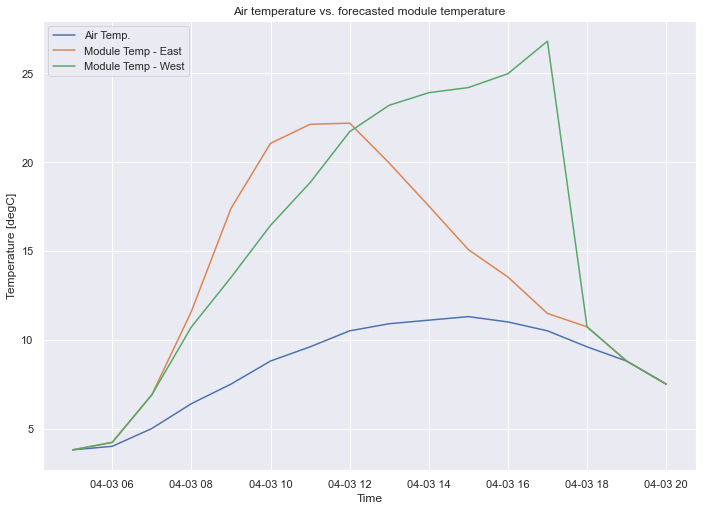

In [27]:
fig, ax = plt.subplots()
ax.set_xlabel("Time") 
ax.set_ylabel("Temperature [degC]")
ax.set_title("Air temperature vs. forecasted module temperature")
sns.lineplot(x=forecast_h.index, y="TEMPERATURE_AIR_200DEGC", data=forecast_h, label="Air Temp.")
sns.lineplot(x=forecast_h.index, y="Ost_cell_temperature", data=forecast_h, label="Module Temp - East")
sns.lineplot(x=forecast_h.index, y="West_cell_temperature", data=forecast_h, label="Module Temp - West")